# Forecast Exploration Notebook
This notebooks on predicting future performance of the world economy and financial markets based on financial time sereis and the world events time series (generated by the NLP workstream).

## DeepAR

In [3]:
# pip install "gluonts[torch]"

In [2]:
# Importing the necessary packages 
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split

from gluonts.torch import DeepAREstimator

from gluonts.evaluation import Evaluator, backtest_metrics
from gluonts.evaluation import make_evaluation_predictions
from gluonts.model.evaluation import evaluate_model
from gluonts.evaluation.metrics import mape

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

/opt/conda/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load Stock-Indices TTS from a CSV file into a DataFrame
file_name = "indices.csv"
file_path = f"../../data_engineering/financial_ts/{file_name}"
tts_df = pd.read_csv(file_path)
# Format DataFrame
tts_col_map = {i:f"ts_f_{i}" for i in tts_df.columns if i.isnumeric()}
tts_df = tts_df.rename(columns={'Unnamed: 0': 'Week'})
tts_df['Week'] = tts_df['Week'].apply(lambda x: datetime.fromisoformat(x))
tts_df = tts_df.set_index('Week')
# Rename Columns
tts_col_map = {i:f"ts_{i}" for i in tts_df.columns}
tts_df = tts_df.rename(columns=tts_col_map)
tts_df.head()

,ts_NASDAQ,ts_S&P,ts_IT_ETF,ts_United_States_Oil_Fund(USO),ts_Farming_ETF,ts_MSCI_World,ts_Emerging_markets,ts_DAX
Week,,,,,,,,
1971-02-08,100.839996,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-02-15,102.050003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-02-22,99.680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-03-01,101.779999,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-03-08,104.230003,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Load Financial RTS from a CSV file into a DataFrame
file_name = "ww_gdp.csv"
file_path = f"../../data_engineering/financial_ts/{file_name}"
rts_f_df = pd.read_csv(file_path)
# Format DataFrame
# rts_f_col_map = {i:f"rts_f_{i}" for i in rts_f_df.columns if i.isnumeric()}
rts_f_df = rts_f_df.rename(columns={'Unnamed: 0': 'Week'})
rts_f_df['Week'] = rts_f_df['Week'].apply(lambda x: datetime.fromisoformat(x))
rts_f_df = rts_f_df.set_index('Week')
# Rename Columns
rts_f_col_map = {i:f"ts_{i}" for i in rts_f_df.columns}
rts_f_df = rts_f_df.rename(columns=rts_f_col_map)
rts_f_df.head()

,ts_Aruba,ts_Africa Eastern and Southern,ts_Afghanistan,ts_Africa Western and Central,ts_Angola,ts_Albania,ts_Andorra,ts_Arab World,ts_United Arab Emirates,ts_Argentina,...,ts_Virgin Islands (U.S.),ts_Vietnam,ts_Vanuatu,ts_World,ts_Samoa,ts_Kosovo,ts_Yemen,ts_South Africa,ts_Zambia,ts_Zimbabwe
Week,,,,,,,,,,,,,,,,,,,,,
1960-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Load Event RTS from a CSV file into a DataFrame
file_name = "ts_dgelt_events.csv"
file_path = f"../../data_engineering/timeseries_data/{file_name}"
rts_e_df = pd.read_csv(file_path)
# Format DataFrame
rts_e_col_map = {i:f"ts_{i}" for i in rts_e_df.columns if i.isnumeric()}
rts_e_df = rts_e_df.rename(
    columns=dict({'Unnamed: 0': 'Week'}, **rts_e_col_map)
)
rts_e_df['Week'] = rts_e_df['Week'].apply(lambda x: datetime.fromisoformat(x))
rts_e_df = rts_e_df.set_index('Week')
rts_e_df.index = rts_e_df.index.tz_localize(None)

rts_e_df.head()

,ts_10,ts_11,ts_12,ts_13,ts_14,ts_15,ts_16,ts_17,ts_18,ts_19,...,ts_1712,ts_1721,ts_1722,ts_1723,ts_1724,ts_1821,ts_1822,ts_1823,ts_1831,ts_1832
Week,,,,,,,,,,,,,,,,,,,,,
2015-02-23,4023.0,NaN,396.0,136.0,NaN,NaN,NaN,121.0,NaN,NaN,...,122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-02,3376.0,NaN,778.0,720.0,140.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1652.0,NaN,130.0,NaN,NaN,NaN,NaN
2015-03-09,1729.0,NaN,2668.0,150.0,160.0,123.0,130.0,NaN,NaN,NaN,...,140.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-16,2483.0,NaN,1190.0,160.0,130.0,NaN,NaN,820.0,NaN,NaN,...,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-23,4433.0,296.0,578.0,296.0,480.0,NaN,180.0,NaN,127.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,260.0,NaN


In [6]:
# Join TTS and RTS into a single DataFrame
ts_df = tts_df.join(rts_e_df).join(rts_f_df)
ts_df = ts_df.reset_index()
ts_df.head()

,Week,ts_NASDAQ,ts_S&P,ts_IT_ETF,ts_United_States_Oil_Fund(USO),ts_Farming_ETF,ts_MSCI_World,ts_Emerging_markets,ts_DAX,ts_10,...,ts_Virgin Islands (U.S.),ts_Vietnam,ts_Vanuatu,ts_World,ts_Samoa,ts_Kosovo,ts_Yemen,ts_South Africa,ts_Zambia,ts_Zimbabwe
0,1971-02-08,100.839996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.276266,NaN,NaN,NaN,4.278934,-0.08604,8.917587
1,1971-02-15,102.050003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.276266,NaN,NaN,NaN,4.278934,-0.08604,8.917587
2,1971-02-22,99.680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.276266,NaN,NaN,NaN,4.278934,-0.08604,8.917587
3,1971-03-01,101.779999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.276266,NaN,NaN,NaN,4.278934,-0.08604,8.917587
4,1971-03-08,104.230003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.276266,NaN,NaN,NaN,4.278934,-0.08604,8.917587


In the following cell the pandas dataframe is converted into a [Dataset](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.pandas.html) which gives the data additional explicid structure.

In [7]:
# Define Target and RTS columns
target_col = 'ts_MSCI_World'
past_rts_col = list(rts_e_col_map.values()) + list(rts_f_col_map.values())

In [8]:
# Target has to be a single value: https://ts.gluon.ai/stable/getting_started/models.html
dataset = PandasDataset(
    ts_df,
    target=target_col, #single value
    timestamp='Week',
    freq='W',
    past_feat_dynamic_real=past_rts_col #list
)

In [9]:
# Split the data for training and testing
training_data, test_gen = split(dataset, offset=-56)
test_data = test_gen.generate_instances(prediction_length=56, windows=1)

In [10]:
prediction_length=56
num_layers=2
hidden_size=40
max_epochs = 10

In [11]:
# Train the model and make predictions
predictor = DeepAREstimator(
    prediction_length=prediction_length, 
    freq="W", 
    num_layers=num_layers, # Number of RNN layers (default: 2).
    hidden_size=hidden_size, # Number of RNN cells for each layer (default: 40).
    trainer_kwargs={"max_epochs": max_epochs}
).train(training_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(

  | Name  | Type        | Params | In sizes | Out sizes   
-------------------

Epoch 0: : 50it [00:12,  3.91it/s, v_num=63, train_loss=1.120]

Epoch 0, global step 50: 'train_loss' reached 1.11829 (best 1.11829), saving model to '/root/project_submission_haiperformer/modelling/exploration/lightning_logs/version_63/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: : 50it [00:12,  3.92it/s, v_num=63, train_loss=0.938]

Epoch 1, global step 100: 'train_loss' reached 0.93816 (best 0.93816), saving model to '/root/project_submission_haiperformer/modelling/exploration/lightning_logs/version_63/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: : 50it [00:12,  3.91it/s, v_num=63, train_loss=0.877]

Epoch 2, global step 150: 'train_loss' reached 0.87667 (best 0.87667), saving model to '/root/project_submission_haiperformer/modelling/exploration/lightning_logs/version_63/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: : 50it [00:12,  3.99it/s, v_num=63, train_loss=0.921]

Epoch 3, global step 200: 'train_loss' was not in top 1


Epoch 4: : 50it [00:13,  3.78it/s, v_num=63, train_loss=0.758]

Epoch 4, global step 250: 'train_loss' reached 0.75757 (best 0.75757), saving model to '/root/project_submission_haiperformer/modelling/exploration/lightning_logs/version_63/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: : 50it [00:12,  3.93it/s, v_num=63, train_loss=0.808]

Epoch 5, global step 300: 'train_loss' was not in top 1


Epoch 6: : 50it [00:12,  3.91it/s, v_num=63, train_loss=0.802]

Epoch 6, global step 350: 'train_loss' was not in top 1


Epoch 7: : 50it [00:13,  3.82it/s, v_num=63, train_loss=0.839]

Epoch 7, global step 400: 'train_loss' was not in top 1


Epoch 8: : 50it [00:12,  3.98it/s, v_num=63, train_loss=0.783]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: : 50it [00:13,  3.71it/s, v_num=63, train_loss=0.912]

Epoch 9, global step 500: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: : 50it [00:13,  3.69it/s, v_num=63, train_loss=0.912]


In [ ]:
forecasts_it = list(predictor.predict(test_data.input))
# Plot predictions
plt.plot(tts_df[target_col]["2016":], color="black")
for forecast in forecasts_it:
  forecast.plot()
plt.legend(["True values"], loc="upper left", fontsize="xx-large")

In [12]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_data.dataset,
        predictor=predictor,
        num_samples=100,
)
forecasts = list(forecast_it)
tss = list(ts_it)

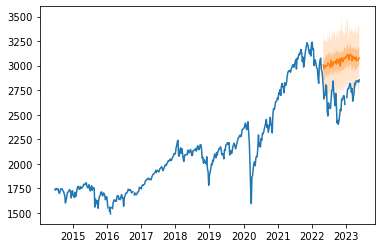

In [16]:
for ts, forecast in zip(tss, forecasts):
    plt.plot(ts.to_timestamp())
    forecast.plot()
plt.savefig("chart_1.svg")

In [17]:
# Does not work !
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])  # Define the quantiles for evaluation
agg_metrics, item_metrics = evaluator(tss, forecasts)

Running evaluation: 1it [00:00, 12.82it/s]


In [18]:
agg_metrics

{'MSE': 408004.57240360905,
 'abs_error': 33835.08715768751,
 'abs_target_sum': 144945.400147,
 'abs_target_mean': 2684.1740767962965,
 'seasonal_error': 33.05533570719603,
 'MASE': 18.95535697037017,
 'MAPE': 0.23589830649439886,
 'sMAPE': 0.20991116751814262,
 'MSIS': 168.45737311280251,
 'QuantileLoss[0.1]': 33317.82333891562,
 'Coverage[0.1]': 1.0,
 'QuantileLoss[0.5]': 33835.08715768751,
 'Coverage[0.5]': 1.0,
 'QuantileLoss[0.9]': 9869.362548725,
 'Coverage[0.9]': 1.0,
 'RMSE': 638.7523560845855,
 'NRMSE': 0.23796979547875305,
 'ND': 0.23343332815924345,
 'wQuantileLoss[0.1]': 0.22986464768889195,
 'wQuantileLoss[0.5]': 0.23343332815924345,
 'wQuantileLoss[0.9]': 0.06809020871801201,
 'mean_absolute_QuantileLoss': 25674.091015109374,
 'mean_wQuantileLoss': 0.17712939485538245,
 'MAE_Coverage': 0.5,
 'OWA': nan}

In [ ]:
experiment_config = Forecast_Experiment(
    model = 'torch_deepar',
    target = target_col,
    past_rts_col = str(past_rts_col),
    epochs = max_epochs,
    prediction_length = prediction_length,
    num_layers = num_layers,
    hidden_size = hidden_size,
    MASE = agg_metrics['MASE'],
    MAPE = agg_metrics['MAPE'],
    RMSE = agg_metrics['RMSE'],
    wQL_10 = agg_metrics['wQuantileLoss[0.1]'],
    wQL_50 = agg_metrics['wQuantileLoss[0.5]'],
    wQL_90 = agg_metrics['wQuantileLoss[0.9]'],
    avg_wQL = agg_metrics['mean_wQuantileLoss']
)
session.add(experiment_config)
session.commit()

## MXNET DeepAR

In [44]:
from gluonts.mx import DeepAREstimator as MXDeepAR, Trainer

In [46]:
mx_model = MXDeepAR(
    prediction_length=56, 
    freq="W",
    trainer=Trainer(epochs=10)
).train(training_data)

100%|██████████| 50/50 [00:15<00:00,  3.24it/s, epoch=10/10, avg_epoch_loss=0.866]


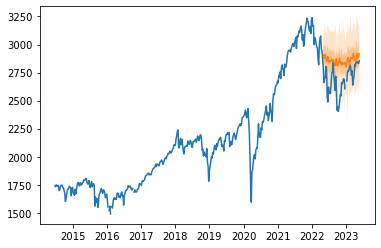

In [48]:
forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_data.dataset,
        predictor=mx_model,
        num_samples=100,
)
forecasts = list(forecast_it)
tss = list(ts_it)

for ts, forecast in zip(tss, forecasts):
    plt.plot(ts.to_timestamp())
    forecast.plot()

## Config Setup

In [19]:
# !pip install sqlalchemy

In [61]:
from sqlalchemy import create_engine, Column, Integer, Float, String, ForeignKey, select
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, relationship

In [62]:
Base = declarative_base()

class Forecast_Experiment(Base):
    __tablename__ = 'forecast_experiment'
    id = Column('id', Integer, primary_key=True)
    model = Column('model name', String(20))
    target = Column('target', String(100))
    past_rts_col = Column('past_rts_col', String(1000))
    epochs = Column('epochs', Integer)
    prediction_length = Column('prediction_length', Integer)
    num_layers = Column('num_layers', Integer)
    hidden_size = Column('hidden_size', Integer)
    MASE = Column('MASE', Float)
    MAPE = Column('MAPE', Float)
    RMSE = Column('RMSE', Float)
    wQL_10 = Column('wQL_01', Float)
    wQL_50 = Column('wQL_50', Float)
    wQL_90 = Column('wQL_90', Float)
    avg_wQL = Column('avg_wQL', Float)

<ipython-input-62-9eca5a238d76>:1: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [63]:
# engine = create_engine('sqlite:///:memory:', echo=True)
engine = create_engine("sqlite:///../config/forecast_config.db")

Base.metadata.create_all(bind=engine)
Session = sessionmaker(bind=engine)
session = Session()

In [ ]:
q1 = select(Forecast_Experiment)
q1_result = session.execute(q1) 
for s in q1_result.scalars():
    print(f"{s.model}: /n avg_wQL = {s.avg_wQL}")